# Example Analysis of historical data and predictions

In [1]:
import os
import sys
sys.path.append("../analysis")
sys.path.append("../utils")

import pandas as pd

from data_import import read_dex_data, read_raindex_data, read_model_predictions  
import evaluation as ev
import visualization as vis
import utils

Import historical raindex data. Find trading frequiency trends.

In [2]:
# Name of the csv file with historical strategy data
raindex_filename = 'base-0x667d65a1e17d71bb20526fb22619d7d131ef7e832186eb4608606e7c7043d612.csv'
# Read the csv and process dataframe accordingly
raindex_df = read_raindex_data(csv_path=utils.get_data_path(raindex_filename, 'trade'))
# Add column with time window between consecutive transactions in mins
raindex_df = utils.add_timestamp_diffs(raindex_df)

In [3]:
# Display the first few rows and show number of transactions with respective operation time window 
ev.display_df_info(raindex_df, 'timestamp_date')

The dataframe contains total of 189 entries from 2025-03-20 07:18:57 to 2025-04-06 17:54:49


,timestamp_int,order_hash,order_type,token_a,token_b,token_amount_a,token_amount_b,token_a_usd,token_b_usd,io_ratio,sender,tx_hash,token_price_a,abs_token_b_amount,timestamp_date,timestamp_floored,tx_group,timestamp_diff,time_diff_min
0,1742455137,0x667d65a1e17d71bb20526fb22619d7d131ef7e832186...,DSF,USDC,FloCo,13.119186,18.399459,13.119186,12.460114,0.713020,0xcb5d2b58e160162355f4ef79e723008d4fa39825,0x323bf1d72dfd50403de8e44814cf1249091dbe6341a1...,1.402485,18.399459,2025-03-20 07:18:57,2025-03-20 07:18:57,1,0,0
1,1742455921,0x667d65a1e17d71bb20526fb22619d7d131ef7e832186...,DSF,FloCo,USDC,25.789181,17.898333,17.464434,17.898333,1.440871,0xc37570809df38b06540e259eda187f7210299d3d,0xf455263cacd03956d86afba93999cf778525504aa5f0...,0.694025,17.898333,2025-03-20 07:32:01,2025-03-20 07:32:01,2,784,13
2,1742458601,0x667d65a1e17d71bb20526fb22619d7d131ef7e832186...,DSF,FloCo,USDC,20.548602,13.953465,13.915513,13.953465,1.472652,0xcb5d2b58e160162355f4ef79e723008d4fa39825,0x0a5fda492167af430c724c928d276ff5e65f7fb19e42...,0.679047,13.953465,2025-03-20 08:16:41,2025-03-20 08:16:41,3,2680,44
3,1742458631,0x667d65a1e17d71bb20526fb22619d7d131ef7e832186...,DSF,FloCo,USDC,7.540781,5.000000,5.106617,5.000000,1.508156,0x29384a295cce669b9edcd96e1ad41127e4340caf,0xd2c9b8e94831d8ac062445d4561bc53acae08fbd6b78...,0.663061,5.000000,2025-03-20 08:17:11,2025-03-20 08:17:11,4,30,0
4,1742458723,0x667d65a1e17d71bb20526fb22619d7d131ef7e832186...,DSF,FloCo,USDC,7.687178,5.000000,5.205757,5.000000,1.537436,0xc92be5c1a82da1ab3984a3923dcc5d8576279c7d,0xcbb76dfac2972d6fde1d35b19b2c4c13c06302991c97...,0.650434,5.000000,2025-03-20 08:18:43,2025-03-20 08:18:43,5,92,1


In [4]:
# Calculate trade frequency statistics
trade_stat = ev.describe_distribution(raindex_df['time_diff_min'], skip_first_in_min=True)
ev.print_stat(trade_stat, 'Time between trades in minutes')


Distribution Characteristics (Time between trades in minutes):
Min: 0.0000
Max: 2050.0000
Mean: 132.4021
Median: 49.0000
Standard Deviation: 229.8248
Interquartile Range (IQR): 124.0000
Skewness: 4.5757
Kurtosis: 28.9735


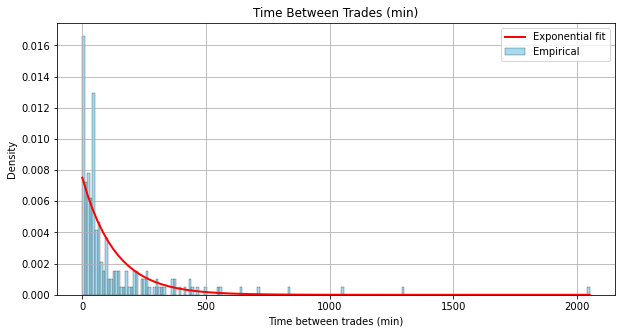

In [5]:
# Plot histogram and fit exponential distribution to the transaction time windows.
# Skip first row 
vis.plot_trade_time_hist(raindex_df[1:], time_unit = 'min', bins = 200, kde = False)

Import pool data and filter transactions to match the raindex trading time window

In [6]:
# Name of the csv file with historical pool data
pool_filename = 'floco-usdc-pool-.csv'
# Read the csv and process dataframe accordingly
pool_df = read_dex_data(csv_path=utils.get_data_path(pool_filename, 'trade'))

In [7]:
# Display the first few rows and show number of transactions with respective operation time window
ev.display_df_info(pool_df, 'timestamp_date')

The dataframe contains total of 17018 entries from 2025-03-19 14:00:09 to 2025-04-14 09:44:19


,block_number,tx_hash,token_amount_a,token_amount_b,timestamp_int,token_price_a,abs_token_b_amount,timestamp_date,timestamp_floored,tx_group
0,27801731,0x3d085a0e075d485422c622a9a4066e2f0ed224fed123...,13000.000000,11042.312479,1742392809,0.849409,11042.312479,2025-03-19 14:00:09,2025-03-19 14:00:00,1
1,27801731,0x0b3922ab44e07eb9534bd8650cccf1df56cad4f299a7...,10000.000000,12400.796189,1742392809,1.240080,12400.796189,2025-03-19 14:00:09,2025-03-19 14:00:00,1
2,27801732,0xd56f6ab5b11f682ed1fb6d7d5b3cd609a6e7af9c5a67...,1.991709,1.367942,1742392811,0.686818,1.367942,2025-03-19 14:00:11,2025-03-19 14:00:00,1
3,27801732,0x571122f21fba714be6849749751014adbf7021125115...,1.991713,1.390494,1742392811,0.698140,1.390494,2025-03-19 14:00:11,2025-03-19 14:00:00,1
4,27801732,0x6a8a7dd6271d112d47a57487d2580583615f17738cb8...,1.991705,1.367865,1742392811,0.686781,1.367865,2025-03-19 14:00:11,2025-03-19 14:00:00,1


In [8]:
# Filter transactions by raindex trading time window 
matched_pool_df = utils.filter_by_timestamp_range(raindex_df, pool_df, 'timestamp_date', 'timestamp_date')
ev.display_df_info(matched_pool_df, 'timestamp_date')

The dataframe contains total of 7187 entries from 2025-03-20 07:18:57 to 2025-04-06 17:54:49


,block_number,tx_hash,token_amount_a,token_amount_b,timestamp_int,token_price_a,abs_token_b_amount,timestamp_date,timestamp_floored,tx_group
557,27832895,0x323bf1d72dfd50403de8e44814cf1249091dbe6341a1...,13.194039,18.399459,1742455137,1.394528,18.399459,2025-03-20 07:18:57,2025-03-20 07:15:00,55
558,27832915,0x50f139a0ff58fd9cc094047d21ac3550162358cb9c0a...,664.574642,940.290000,1742455177,1.414875,940.290000,2025-03-20 07:19:37,2025-03-20 07:15:00,55
559,27832949,0x3fc0c382c2be45dfe62897820ead19fb73e70f6af633...,2614.640955,3531.648885,1742455245,1.350720,3531.648885,2025-03-20 07:20:45,2025-03-20 07:15:00,55
560,27832961,0x95847b841e5cabcbeae45c731ae312c4b957ee58fb33...,686.261210,895.510000,1742455269,1.304911,895.510000,2025-03-20 07:21:09,2025-03-20 07:15:00,55
561,27832967,0xb6b15d810136b2e3e847fbf0df91d125de038818f8a2...,666.996064,895.060000,1742455281,1.341927,895.060000,2025-03-20 07:21:21,2025-03-20 07:15:00,55


In [9]:
# Write into csv file to be used in the model spreadsheet
matched_pool_df.to_csv(utils.get_data_path('matched_{}'.format(pool_filename), 'trade'), index=False)
# These transactions need to be used in the model to compare predictions vs actual

Load predictions from the model using the filtered data from above

In [10]:
# Name of the spreadsheet model file that uses previously filtered by date historical pool data 
pool_model_file_name = r'model-floco_pool_matched_time.xlsx'
# Choose the name of the sheet for analysis in the model
trade_freq_sheet = '15M'
# Read data from the model into dataframe
pool_15m_df = read_model_predictions(file_path=utils.get_data_path(pool_model_file_name, 'model'), sheet_name=trade_freq_sheet)
# Calculate trade counts from resets
utils.add_reset_trade_count(pool_15m_df)

In [11]:
# Display transactions that resulted in reset 
display(pool_15m_df[pool_15m_df['reset']])


,time_interval,executed_auction_price,amount,cumulative_amount,strategy_auctions,date_time,average_price,cumulative_reset,gap,price_gap,...,amount1,duration_x,auction_count_in_reset,last_reset_sp,recent_reset_sp,moving_average,last_reset,recent_reset,reset,trade_count
4,45736.34375,1.513522,6540.326570,27480.69924,1.0,2025-03-20 08:15:00.000,1.442752,27480.69924,-0.070770,-0.013060,...,6540.326570,0.25,5.0,0.0,28.0,#REF!,-1,4,True,5
45,45737.64583,1.569774,1173.672772,54078.43427,1.0,2025-03-21 15:29:59.712,1.462297,26597.73503,-0.107477,-0.048985,...,1173.672772,0.25,41.0,28.0,69.0,1.462297,4,45,True,41
147,45741.62500,1.534967,1520.000000,93719.89196,1.0,2025-03-25 15:00:00.000,1.474914,39641.45769,-0.060053,-0.001056,...,1520.000000,0.25,102.0,69.0,171.0,1.474914,45,147,True,102
208,45743.47917,1.428937,232.037830,113277.54970,1.0,2025-03-27 11:30:00.288,1.367569,19557.65774,-0.061368,-0.006666,...,232.037830,0.25,61.0,171.0,232.0,1.367569,147,208,True,61
959,45751.44792,1.426313,995.756450,484706.21420,1.0,2025-04-04 10:45:00.288,1.313427,371428.66450,-0.112886,-0.060349,...,995.756450,0.25,751.0,232.0,983.0,1.313427,208,959,True,751
1016,45752.04167,1.583604,1174.252312,539572.18450,1.0,2025-04-05 01:00:00.288,1.408778,54865.97036,-0.174826,-0.118475,...,1174.252312,0.25,57.0,983.0,1040.0,1.408778,959,1016,True,57


In [12]:
# Name of the spreadsheet model file that uses raindex trading data 
raindex_model_file_name = 'model-floco_raindex.xlsx'#r'model-floco_raindex_no_group.xlsx'
# Choose the name of the sheet for analysis in the model
trade_freq_sheet = '15M'
# Read data from the model into dataframe
raindex_15m_df = read_model_predictions(file_path=utils.get_data_path(raindex_model_file_name, 'model'), sheet_name=trade_freq_sheet)
# Calculate trade counts from resets
utils.add_reset_trade_count(raindex_15m_df)

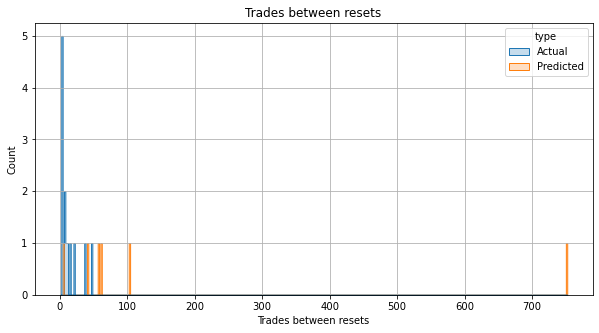

In [13]:
# Plot comparison of the actual vs predicted number of transactions between resets
max_trade_threshold = 1000000 # Optional filter for the maximum number or trades
                                # Useful to eliminate outliers in the plot for visual comparison
                                # Set at some large number if filtering is not required 
# Change bin_width to change grouping in histogram
vis.plot_reset_trades_hist(raindex_15m_df[raindex_15m_df['trade_count']<max_trade_threshold], 
                           pool_15m_df[pool_15m_df['trade_count']<max_trade_threshold], bin_width=2)

The plot shows one outlier at 751. Could be more reasonable to drop that entry and compare without such large numbers, given the actual data distribution.

In [14]:
# Generate comparison for trades between resets statistics
stat_comparison_df = ev.compare_distributions(raindex_15m_df, pool_15m_df)
display(stat_comparison_df)

,Actual,Predicted
mean,11.857143,169.500000
median,6.500000,59.000000
std,13.738532,286.600593
min,2.000000,5.000000
max,46.000000,751.000000
iqr,10.000000,46.750000
skew,1.588639,1.740772
kurtosis,1.205777,1.114371
95% CI lower,3.924751,-131.268877
95% CI upper,19.789535,470.268877


In [15]:
# Get only trade_counts from entries which indicate reset
actual = raindex_15m_df.loc[raindex_15m_df['reset'], 'trade_count']
predicted = pool_15m_df.loc[pool_15m_df['reset'], 'trade_count']

# Evaluate given distributions using Welch’s t-test and Mann–Whitney U tests
# Important to note that t-test asumes data normality and compares means when variances are different
# Mann–Whitney U test compares medians and distribution shapes with no normality assumption
hypothesis_eval = ev.perform_hypothesis_tests(actual, predicted, alpha=0.05)

# Display as DataFrame
hypothesis_df = pd.DataFrame.from_dict(hypothesis_eval, orient='index', columns=['Value'])
# If test is significant we reject the null hypothesis 
# t-test null hypothesis: equal means
# Mann–Whitney U test: equal ranks (similar distribution)
display(hypothesis_df)

,Value
t-test p-value,0.235801
t-test significant,False
Mann–Whitney U p-value,0.00724
Mann–Whitney U significant,True


From the table above t-test is not statistically significant, so we cannot reject that means are not the same. However, this particular case has small number of entries, which could be something to look into. 
From Mann–Whitney U test showed statistical significance to reject similarity in ranks, possibly implying samples being from different distributions.

In [16]:
# Find the minimum number of resets from actual and prediction data 
min_resets = min(raindex_15m_df['reset'].sum(), pool_15m_df['reset'].sum())

# Reduce the number of entries to the minimum reset number from above.
actual_resets = raindex_15m_df[raindex_15m_df['reset']][:min_resets]
predicted_resets = pool_15m_df[pool_15m_df['reset']][:min_resets]

# Calculate error metrics of actual vs predicted
prediction_error = ev.calculate_prediction_error(actual_resets, predicted_resets, 'trade_count', 'trade_count')
print('Transaction counts from the top {} resets are compared from actual and predicted datasets. -->'.format(min_resets))
print('Mean Absolute Error (MAE): {}'.format(round(prediction_error['MAE'], 2)))
print('Root Mean Squared Error (RMSE): {}'.format(round(prediction_error['RMSE'], 2)))
print('Mean Absolute Percentage Error (MAPE): {}'.format(round(prediction_error['MAPE'], 2)))

Transaction counts from the top 6 resets are compared from actual and predicted datasets. -->
Mean Absolute Error (MAE): 161.67
Root Mean Squared Error (RMSE): 309.39
Mean Absolute Percentage Error (MAPE): 5119.25


The above is the comparison of various error metrics between actual data and predictions. It is important to choose proper alignment between actual and predicted transaction counts. Currently, the actual and predicted values are aligned according to the reset order. 

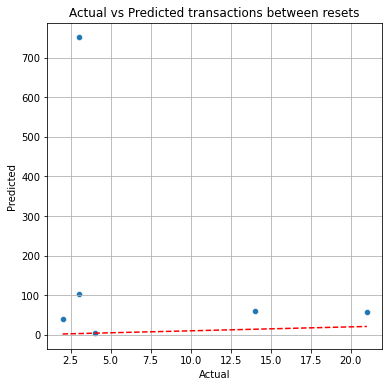

In [17]:
# Plot predicted vs actual data.
vis.plot_predictions_vs_actual(actual_resets, predicted_resets, 'trade_count', 'trade_count', 'Actual vs Predicted transactions between resets')

The data is skewed towards predicted, implying prediction values are heavier than actual. As indicated earlier, one may decide to eliminate outliers first then perform the analysis. 

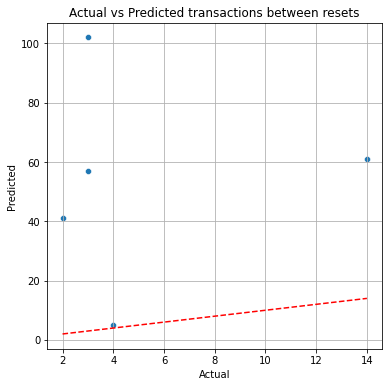

In [18]:
# Filter the predicted data to eliminate the outlier and reduce actual data to the same size
predicted_resets_reduced = pool_15m_df[pool_15m_df['reset']]
predicted_resets_reduced = predicted_resets_reduced[predicted_resets_reduced['trade_count'] < 150]
predicted_resets_reduced = predicted_resets_reduced[:min_resets]
actual_resets_reduced = actual_resets[:len(predicted_resets_reduced)]
# Plot predicted vs actual
vis.plot_predictions_vs_actual(actual_resets_reduced, predicted_resets_reduced, 'trade_count', 'trade_count', 'Actual vs Predicted transactions between resets')

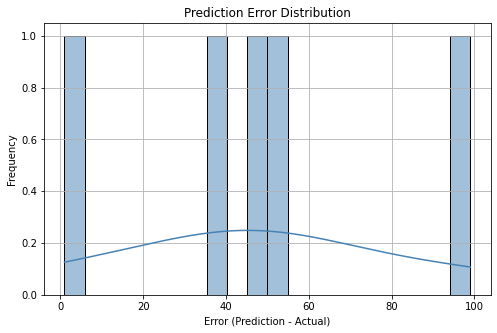

In [21]:
# Plot error between prediction and actual data.
# Outlier filtered data is used
vis.plot_error_distribution(actual_resets_reduced, predicted_resets_reduced, 'trade_count', 'trade_count')